In [1]:
# Required packages
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.graphics.api import qqplot
from sklearn.preprocessing import scale
import warnings
import statsmodels.graphics.tsaplots as splt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

%matplotlib inline

C:\Users\chris\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\chris\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


I initially was using data from the UCI repository, but the data was in months. This was causing some grief for me due to the large number of significant lags. The statsmodels package has the same dataset, but grouped into years. It was much easier for me to deal with. 

In [2]:
# load data set from statsmodels
df = sm.datasets.sunspots.load_pandas().data

In [3]:
# quick look at data. 
df.head()

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


We need to convert the year column to a datetime object and set that as the index for our analysis. Once we do that we no longer need the year column. I'll rename he sunactivity column too.

In [4]:
# set index as datetime
df.set_index(pd.to_datetime(df['YEAR'], format="%Y"), inplace=True)

#drop year column
df.drop(columns='YEAR', inplace=True)

# rename columm
df.rename(columns={'SUNACTIVITY':'Count'}, inplace=True)

In [5]:
# normalize data
df['Count'] = scale(df['Count'])

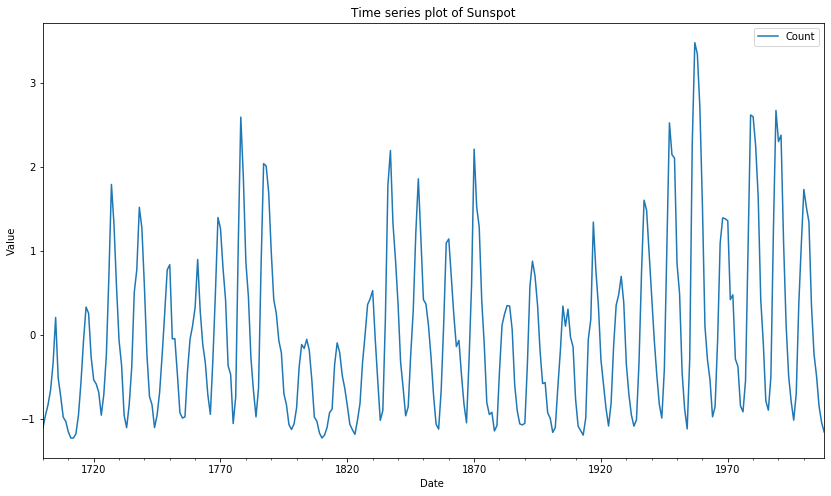

In [6]:
fig = plt.figure(figsize=(14, 8))
ax = fig.gca()
df.plot(ax=ax)
plt.title('Time series plot of Sunspot')
plt.ylabel('Value')
plt.xlabel('Date ')
plt.show()

## Determining AR & MA Parameters
Below we can see that there are a few significant lag values and some obvious seasonal components to the data. The previous data I was dealing with (in months) had many more significant lag values. 

It appears our AR term should be 2 from looking at the PACF and our MA term should be 2 as well (from ACF).

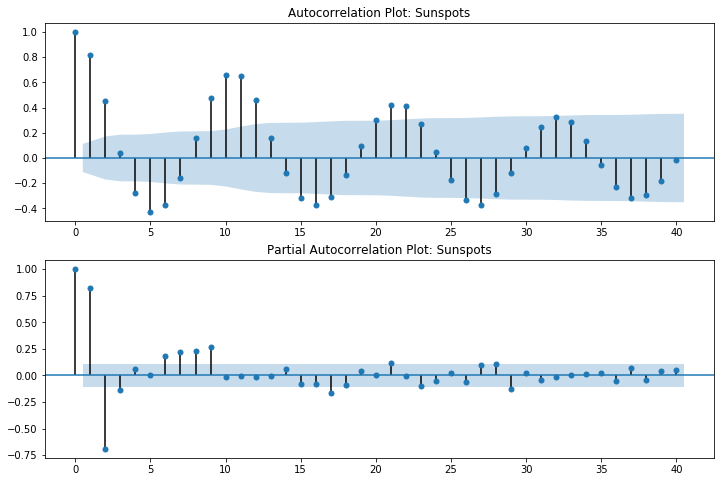

In [7]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2, 1, 1)
fig = splt.plot_acf(df.values.squeeze(), lags=40, ax=ax1, title='Autocorrelation Plot: Sunspots')
ax2 = fig.add_subplot(2, 1, 2)
fig = splt.plot_pacf(df, lags=40, ax=ax2, title='Partial Autocorrelation Plot: Sunspots')

## Is Our Time Series Stationary?

Below we perform a DF test to determine if our data is stationary. The p-value is fairly is near our significance level and we can reject the null hypothesis of the test and conclude our data is stationary. This means our integrative, or d value, should be 0.  

It is a pretty close call here I should note and if our fit isn't great we can revisit this idea. 

In [8]:
def DF_Test(ts):
    stationary = adfuller(ts)
    ## Print the results
    print('DickyFuller statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))

DF_Test(df)

DickyFuller statistic = -2.837780724938193
p-value = 0.05307642172812084


## SARIMAX Model 

Because normal ARIMA does not support the seasonal patterns in a time series, we can use SARIMAX function from statsmodels to account for this. I previously applied ARIMA modeling to this data and the results weren't too great, so I removed it from the notebook. 

There are several seasonal parameters similar to the (p, d, q) values of basic ARIMA, which are (P,D,Q,s). 
- If your model has well defined seasonal patterns, then set the D value to 1.
- Our P value will be set to the p value for now
- Our Q value will be set to the q value for now
- our s value should be 10 or 11 as this appears to be the seasonality for our sunspot cycle. 

Putting this all together our model is SARIMAX$(2, 0, 2)x(2, 1, 2)_{10}$

In [9]:
model = sm.tsa.statespace.SARIMAX(df[:-20], order=(2,0,2), seasonal_order=(2,1,2,10))
results = model.fit()
print(results.summary())

C:\Users\chris\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\chris\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                              Count   No. Observations:                  289
Model:             SARIMAX(2, 0, 2)x(2, 1, 2, 10)   Log Likelihood                -150.906
Date:                            Fri, 27 Mar 2020   AIC                            319.813
Time:                                    10:28:35   BIC                            352.494
Sample:                                01-01-1700   HQIC                           332.923
                                     - 01-01-1988                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3224      0.149      8.849      0.000       1.029       1.615
ar.L2         -0.6208      0.112   

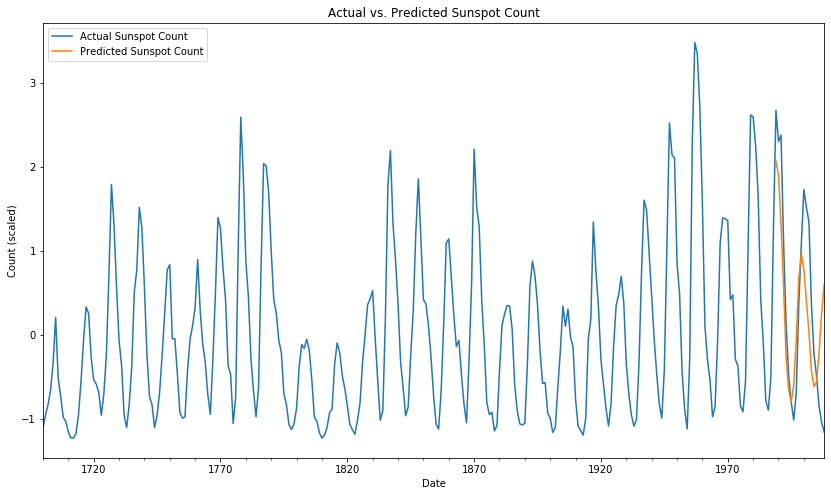

In [10]:
forecast = results.predict('1989-01-01', '2008-01-01', return_conf_int=True) 
fig = plt.figure(figsize=(14, 8))
ax = fig.gca()
df.plot(ax=ax)
forecast.plot(ax=ax)
plt.legend(('Actual Sunspot Count','Predicted Sunspot Count'))
plt.title('Actual vs. Predicted Sunspot Count')
plt.xlabel('Date')
plt.ylabel('Count (scaled)')
plt.show()

Below we used the auto_arima function to grid search for the best performing seasonal arima model. This resulted in the model with parameters (3, 0, 1)x(1, 1, 1, 11).

In [11]:
# import pmdarima as pm
# grid_model = pm.auto_arima(df[:-20], start_p=1, start_q=1,
#                          test='adf',
#                          max_p=3, max_q=3, m=11,
#                          start_P=0, seasonal=True,
#                          d=0, D=1, trace=True,
#                          error_action='ignore',  
#                          suppress_warnings=True, 
#                          stepwise=True)
# print(grid_model.summary())

The results of the auto_arima produced model is shown below with predictions pretty far into the future. I wanted to show that while the predicted results are fairly accurate for dates closer to the start of the predictions, they begin to get pretty crummy as time progresses. 

It seems that it captures the general seasonality, but misses the magnitude of the highs and lows and gets stuck in the means of each. 

C:\Users\chris\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\chris\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


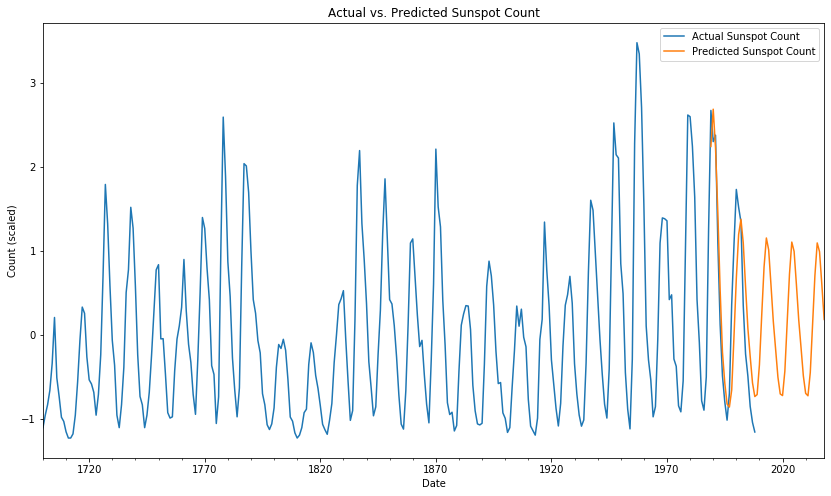

In [12]:
grid_model = sm.tsa.statespace.SARIMAX(df[:-20], order=(3, 0, 1), seasonal_order=(1, 1, 1, 11)).fit()
forecast = grid_model.forecast(50)
fig = plt.figure(figsize=(14, 8))
ax = fig.gca()
df.plot(ax=ax)
forecast.plot(ax=ax)
plt.legend(('Actual Sunspot Count','Predicted Sunspot Count'))
plt.title('Actual vs. Predicted Sunspot Count')
plt.xlabel('Date')
plt.ylabel('Count (scaled)')
plt.show()

## The Residuals

Below we performed a normality test as well as produced a couple plots to determine if our residuals are normally distributed as this indicates a better fit. 

NormaltestResult(statistic=45.33375774103504, pvalue=1.4318567941076437e-10)


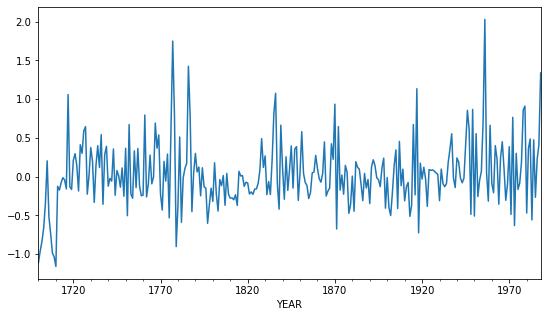

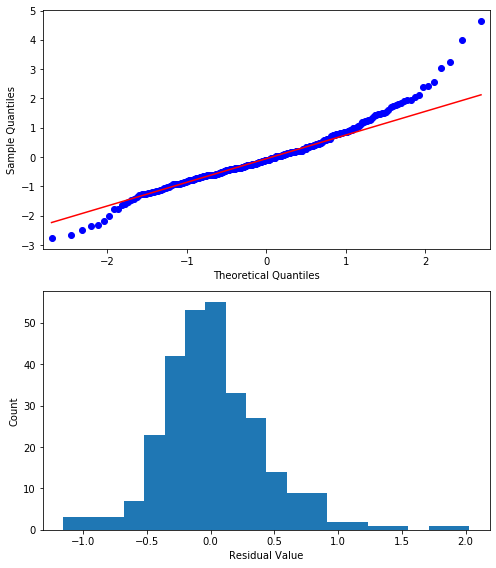

In [13]:
# determine if the residuals are normally distributed
print(ss.normaltest(grid_model.resid))

# plot the residuals
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot()
grid_model.resid.plot(ax=ax)
plt.show()

# quantile plot
fig = plt.figure(figsize=(7, 8))
ax = fig.add_subplot(211)
fig = qqplot(grid_model.resid, line='q', ax=ax, fit=True)
ax = fig.add_subplot(212)
fig = grid_model.resid.hist(bins = 20, grid = False)
plt.xlabel('Residual Value')
plt.ylabel('Count')
plt.tight_layout()

The model is obviously not perfect, but It does appear to do a fair job at predicting 10 to 20 years into the future. 